In [1]:
#import tweepy library
import tweepy
import json 
from collections import Counter
import os
import pickle as pckl
import twitter
import pandas as pnd
import numpy as nmp
import ipywidgets as widget
from IPython.display import display, clear_output
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
import matplotlib.pyplot as plot
from tweepy import Stream
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import time
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import re

#declare and assign values to authorization variables
ConsumerKey = "e8yOMk1PYebFI6IqAmJPac9sY"
ConsumerSecret = "ghdd9BjIIkmIp9rHahIUrj6cLdMzMX35m8xRuDc19D7s4BOVHD"
AccessToken = "3770751192-URKr3kja687MI8HvZ6KcvwvfXEmup0YE9Cc7tyb"
AccessTokenSecret = "2TjrhbSiXOroOQVzWoMQ5ArB2ehIasUJ06hJmBBG9LzCX"
BearerToken = "AAAAAAAAAAAAAAAAAAAAADuIOwEAAAAAsOVffQU%2BTcjto0yCqpjKsjRSYq8%3DrSpogsdTnGTLgPWOxU5tmHvwf3X9n8gsEWLsHLxcy1QACmRlud"

fetchedTweetFileName = "realtimeStreamData.json"

#twitter authorization started
auth = tweepy.OAuthHandler(ConsumerKey, ConsumerSecret)
auth.set_access_token(AccessToken, AccessTokenSecret)

In [2]:
#define a function to return API authorization
def APIAuthorization():
    api = tweepy.API(auth)
    return api

def CleanTweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())

def AnalyseSentiment(tweet):
    analysis= TextBlob(CleanTweet(tweet))
    if analysis.sentiment.polarity>0:
        return 1
    elif analysis.sentiment.polarity==0:
        return 0
    else:
        return -1
    
#spark intialization
spark = SparkSession.builder.appName("PysparkExample") \
            .config ("spark.sql.shuffle.partitions", "50") \
            .config("spark.driver.maxResultSize","5g") \
            .config ("spark.sql.execution.arrow.enabled", "true") \
            .getOrCreate()

In [3]:
#define a variable that can directly be used to get data from twitter API
exractor = APIAuthorization()

In [4]:
#Q1: twitter realtime stream data fetching and injecting into local system file = realtimeStreamData.json, and showing top 10 results
class TwitterStreamer():
    def __init__(self):
        pass
    
    def StrimTweets(self, fetchedTweetFileName, hashTagList):
        listener = StdOutListener(fetchedTweetFileName)
        stream = Stream(auth, listener)
        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hashTagList)
        print(stream)
    

extractor= APIAuthorization()
numberOfTweets= 500
tweets1= extractor.user_timeline(screen_name= "nytimes", count= numberOfTweets)
print("Number of tweets Extracted: {}.\n".format(len(tweets1)))
print("Print recent tweets::\n")
for tweet in tweets1[:numberOfTweets]:
    print(tweet.text)
    print()

#save file to json
tweetData= pnd.DataFrame(data= [tweet.text for tweet in  tweets1],columns= ['Tweets'])
tweetData.to_json(fetchedTweetFileName)

Number of tweets Extracted: 200.

Print recent tweets::

Some of the largest wildfires in U.S. history have burned across the American West this summer. See the latest with… https://t.co/oWCizglls5

Taliban forces are seeking to isolate Kabul, the Pentagon said Friday, taking over border crossings, highways and l… https://t.co/SKjw1tGKBP

Google infringed on speaker-technology patents held by Sonos and should not be allowed to import products that viol… https://t.co/QWSRDNZPeA

In a simulation, we modeled Delta-driven Covid outbreaks in two communities, one with a high vaccination rate and a… https://t.co/dkJqgmjtBF

The number of extremely hot days is rising around the world. See how your hometown has changed since your birth — a… https://t.co/tgHiMe3ff0

Are more multiracial babies being born? Are Americans rethinking their identities? Or did a design change in this y… https://t.co/F44EFXRfnG

RT @fahimabed: While the future of Afghanistan seems more and more uncertain, one thing is 

In [5]:
#Q2: function to dump 50 trending topics (incuding topics) worldwide and print as per choosen from dropdown using pyspark          
btnSearch = widget.Button(
    description = "Search"
)


dropDownSelectNumber = widget.Dropdown(
    options=[('Ten', 10), ('Thirty', 30), ('Fifty', 50)],
    value=10,
    description='Number:',
)

dropDownSelectMinutes = widget.Dropdown(
    options=[('Ten Minutes', 10), ('Thirty Minutes', 30), ('Sixty Minutes', 60)],
    value=10,
    description='Last Minutes:',
)


WOE_ID = 1 #1=worldwide
def PrintTweets():
    clear_output()
    trends = exractor.trends_place(WOE_ID)
    #print(trends)
    trends = json.loads(json.dumps(trends, indent=1))
    trending = []
    for trend in trends[0]["trends"]:
        trending.append(trend["name"])
    trending
    data1= pnd.DataFrame(trending,columns= ['Trends'])
    data1.to_csv('trendingTopics.csv')
    print()
    dataFrameJson = spark.read.csv('trendingTopics.csv', header=True)
    dataFrameJson.show(dropDownSelectNumber.value)
    
    
#define button click function
def TweetsByNumberAndMinutes(b):
    with outputDisplay:
        PrintTweets()
        
   

btnSearch.on_click(TweetsByNumberAndMinutes) 

outputDisplay = widget.Output()

items = [dropDownSelectNumber, dropDownSelectMinutes, btnSearch]
indx = widget.HBox([items[0], items[1], items[2]])
widget.VBox([indx, outputDisplay])




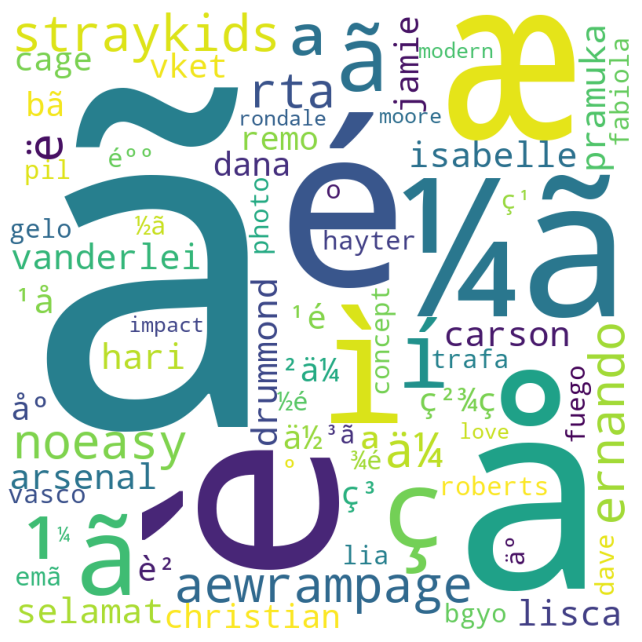

In [7]:
#Q4: showing data in Word Cloud model (Visualising data using Word Cloud model for both 2 and 3)
dataFrame = pnd.read_csv(r"trendingTopics.csv", encoding ="latin-1") 
  
commentWords = '' 
sWords = set(STOPWORDS) 
 
for value in dataFrame.Trends: 
 
    value = str(value) 

    exp = value.split() 
    for i in range(len(exp)): 
        exp[i] = exp[i].lower() 
      
    commentWords += " ".join(exp)+" "
  
wCloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = sWords, 
                min_font_size = 10).generate(commentWords) 
                      
# WordCloud image plotting                    
plot.figure(figsize = (9, 9), facecolor = None) 
plot.imshow(wCloud) 
plot.axis("off") 
plot.tight_layout(pad = 1) 
  
plot.show()

In [22]:
#Q3: top trending tweets
if not os.path.exists('secret_twitter_credentials.pk1'):
    TwitterAuth = {}
    TwitterAuth['Consumer Key'] = ConsumerKey
    TwitterAuth['Consumer Secret'] = ConsumerSecret
    TwitterAuth['Access Token'] = AccessToken
    TwitterAuth['Access Token Secret'] = AccessTokenSecret
    with open('twitterHashTags.csv', 'wb') as f:
        pckl.dump(TwitterAuth, f)
else:
    TwitterAuth = pckl.load(open('twitterHashTags.csv','rb'))
    
auth = twitter.oauth.OAuth(TwitterAuth['Access Token'],
                          TwitterAuth['Access Token Secret'],
                          TwitterAuth['Consumer Key'],
                          TwitterAuth['Consumer Secret'])
twitterAPI = twitter.Twitter(auth=auth)
print(twitterAPI)

topic = input("Enter #topicName: ")
number = 1000
searchResults = twitterAPI.search.tweets(q=topic, count=number)
statuses = searchResults['statuses'] 
len(statuses)   
allText =[]
filteredStatuses=[]
for s in statuses:
    if not s['text'] in allText:
        filteredStatuses.append(s)
        allText.append(s["text"])
statuses= filteredStatuses
len(statuses)
print(json.dumps(statuses[0], indent=1))
t = statuses[0]
print(t['retweet_count'])
print(t['retweeted'])
statusTexts = [status['text']
               for status in statuses]
screenNames = [user_mention['screen_name']
               for status in statuses
                   for user_mention in status['entities']['user_mentions']]
hashtags = [hashtag['text']
               for status in statuses
                   for hashtag in status['entities']['hashtags']]

#compute the collection of the words from all tweets
words = [w
        for t in statusTexts

         for w in t.split()]
print(json.dumps(statusTexts[:5],indent=1))
print(json.dumps(screenNames[:5],indent=1))
print(json.dumps(hashtags[:5],indent=1))
print(json.dumps(words[:5],indent=1))

for item in [words, screenNames, hashtags]:
    c=Counter(item)
    print(c.most_common()[:100]) 
    print() 

def prettyprint_counts(label,list_of_tuples):
    print("\n{:^20} | {:^6}".format(label,"Count"))
    print("*"*40)
    for k,v in list_of_tuples:
        print("{:20} | {:>6}".format(k,v))   
for label, data3 in (('word', words),
                   ('Screen Name', screenNames),
                   ('Hashtag', hashtags)):
    c = Counter(data3)
    prettyprint_counts(label,c.most_common()[:10])  

retweets = [
            (status['retweet_count'],
             status['retweeted_status']['user']['screen_name'],
             status['text'].replace("\n","\\"))
    
             for status in statuses
                if 'retweeted_status' in status
          ]  
row_template = "{:^7} | {:^15} | {:50}"
def prettyprint_tweets(list_of_tuples):
    print()
    print(row_template.format("Likes","Screen Name","Text"))
    print("*"*30)
    for count, screenNames, text in list_of_tuples:
        print(row_template.format(count, screenNames,text[:50]))

        if len(text)>50:
            print(row_template.format("","",text[50:100]))
            if len(text)>100:
                print(row_template.format("","",text[100:])) 

prettyprint_tweets(sorted(retweets, reverse=True)[:100])
data8= pnd.DataFrame(screenNames, columns= ['screenNames'])
data8.to_csv('ScreenName.csv')

Enter #topic_name: test
{
 "created_at": "Sat Aug 14 02:49:12 +0000 2021",
 "id": 1426375322706989060,
 "id_str": "1426375322706989060",
 "text": "RT @RedwanArwa: Test 51\n#\u062c\u0647\u0627\u062f_\u0641\u0636\u0627\u064a\u062d_\u0645\u0631\u0641\u0648\u0636_\u0644\u0644\u0632\u0645\u0627\u0644\u0643",
 "truncated": false,
 "entities": {
  "hashtags": [
   {
    "text": "\u062c\u0647\u0627\u062f_\u0641\u0636\u0627\u064a\u062d_\u0645\u0631\u0641\u0648\u0636_\u0644\u0644\u0632\u0645\u0627\u0644\u0643",
    "indices": [
     24,
     49
    ]
   }
  ],
  "symbols": [],
  "user_mentions": [
   {
    "screen_name": "RedwanArwa",
    "name": "\ud835\udc68\ud835\udc79\ud835\udc7e\ud835\udc68 \ud835\udc79\ud835\udc6c\ud835\udc6b\ud835\udc7e\ud835\udc68\ud835\udc75",
    "id": 1410967197825089542,
    "id_str": "1410967197825089542",
    "indices": [
     3,
     14
    ]
   }
  ],
  "urls": []
 },
 "metadata": {
  "iso_language_code": "en",
  "result_type": "recent"
 },
 "source": "<a href=\"

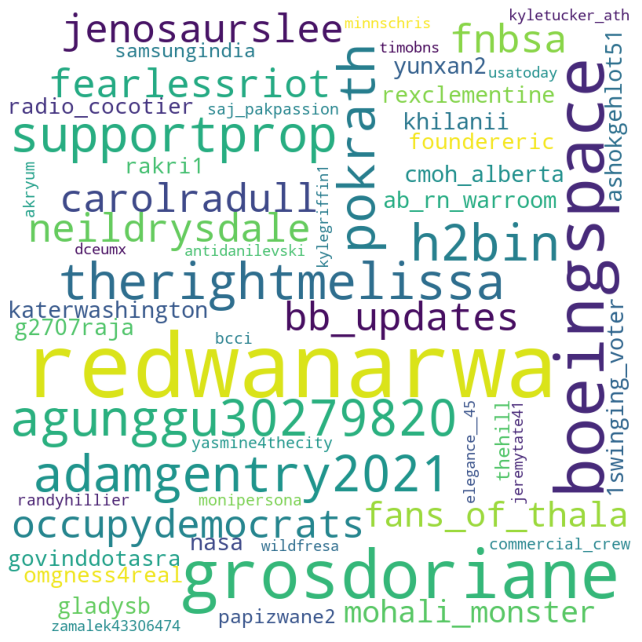

In [14]:
#Q4: showing data in Word Cloud model (Visualising data using Word Cloud model for both 2 and 3)
dataFrame = pnd.read_csv(r"ScreenName.csv", encoding ="latin-1") 
  
commentWords = '' 
stopWords = set(STOPWORDS) 
 
for value in dataFrame.screenNames: 
 
    value = str(value) 

    tokens = value.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    commentWords += " ".join(tokens)+" "
  
wCloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopWords, 
                min_font_size = 10).generate(commentWords) 
                      
# WordCloud image plotting                    
plot.figure(figsize = (9, 9), facecolor = None) 
plot.imshow(wCloud) 
plot.axis("off") 
plot.tight_layout(pad = 1) 
  
plot.show()

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'extended_entities', 'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted',
       'possibly_sensitive', 'lang', 'retweeted_status'],
      dtype='object')
0     112
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
31      0
32      0
33      0
34      0
35      0
36      0
37      0
38      0
Name: favorite_count, dtype: int64


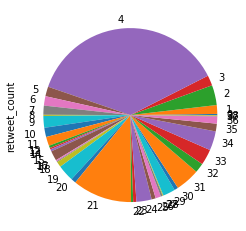

Number of tweets: 39
Total number of likes: 112
Total number of retweets: 12600


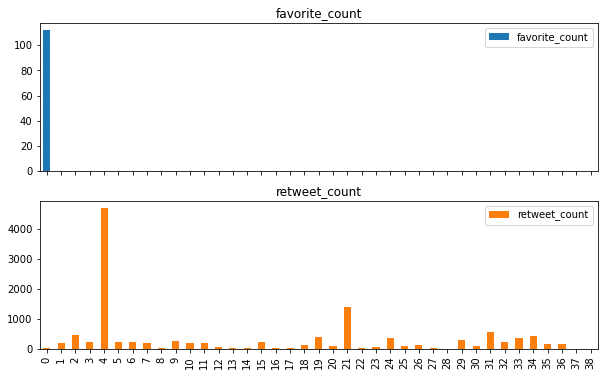

Data for CNN
Number of tweets: 39
Number of likes: 112
Number of likes per tweet: 2.871794871794872
Number of retweets: 12600
Number of retweets per tweet: 323.0769230769231


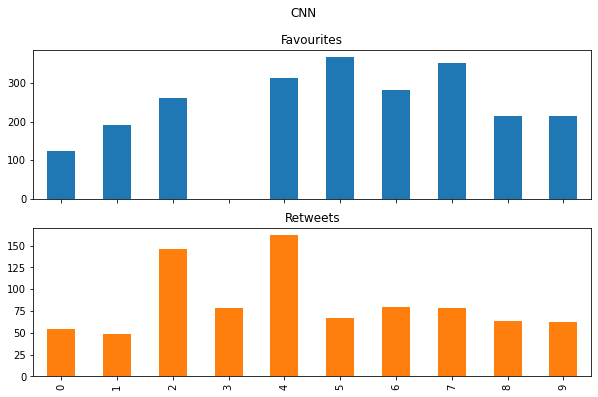

Data for BBCWorld
Number of tweets: 39
Number of likes: 112
Number of likes per tweet: 2.871794871794872
Number of retweets: 12600
Number of retweets per tweet: 323.0769230769231


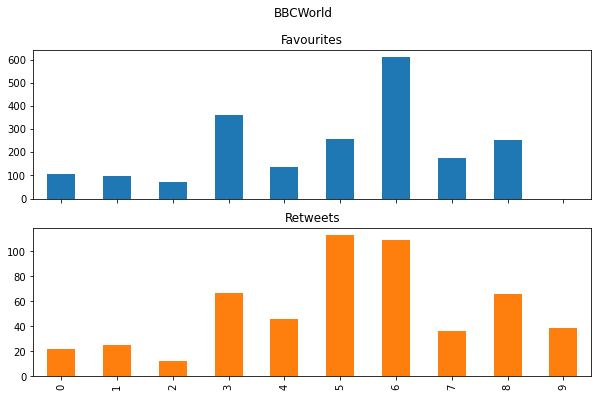

In [24]:
#Q5: Demonstrating any (one or more) additional/arbitrary insights on the data using ML or none-ML data analytics approaches (5% per insight)
auth = twitter.oauth.OAuth(AccessToken, AccessTokenSecret, ConsumerKey, ConsumerSecret)

twitterApi = twitter.Twitter(auth=auth)
tweets = twitterApi.search.tweets(q="BBC", count=100)
tweets = twitterApi.search.tweets(q="from:BBC", count=100)
tweetData = pnd.DataFrame(tweets['statuses'])

print(tweetData.columns)
print(tweetData['favorite_count'])

tweetData['retweet_count'].plot.pie()
plot.show()

# Get the data
tweetCount = len(tweetData)
favoriteCount = tweetData['favorite_count'].sum()
retweetCount = tweetData['retweet_count'].sum()

# Print it out
print('Number of tweets: ' + str(tweetCount))
print('Total number of likes: ' + str(favoriteCount))
print('Total number of retweets: ' + str(retweetCount))

# Draw a nice plot of the likes and retweets
tweetData.plot.bar(subplots=True, figsize=(10,6),y=['favorite_count','retweet_count'])
plot.show()
names = ['CNN','BBCWorld']
for name in names:
  tweets = pnd.DataFrame(twitterApi.search.tweets(q="from:"+name, count=10)['statuses'])
  tweet_count = len(tweets)
  favorite_count = tweets['favorite_count'].sum()
  retweet_count = tweets['retweet_count'].sum()

  print("Data for "+name)
  print('Number of tweets: ' + str(tweetCount))
  print('Number of likes: ' + str(favoriteCount))
  print('Number of likes per tweet: '+str(favoriteCount/tweetCount))
  print('Number of retweets: ' + str(retweetCount))
  print('Number of retweets per tweet: '+str(retweetCount/tweetCount))

  tweets.plot.bar(subplots=True, figsize=(10,6),y=
    ['favorite_count','retweet_count'],
    legend=False,label=['Favourites','Retweets'],title=name)

  plot.show()

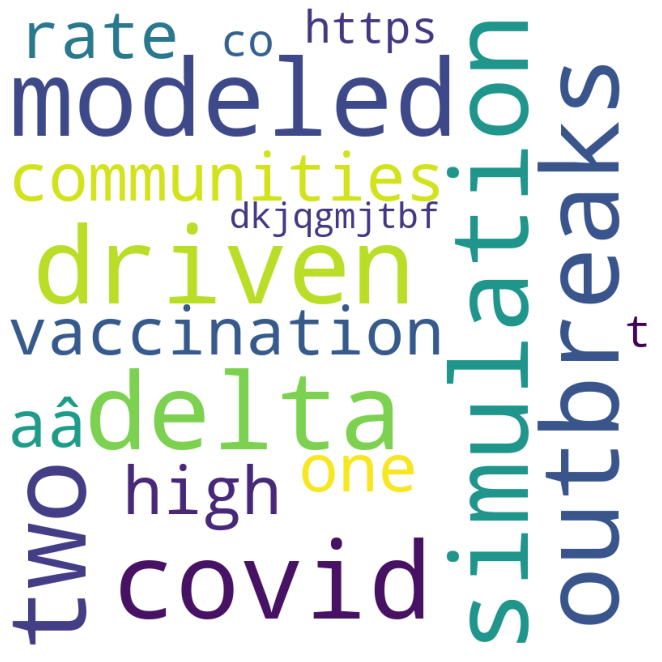

In [11]:
dataFrame = pnd.DataFrame(data = tweetData)
dataFrame.to_csv('file4.csv', index=False, header=None)
dataFrame = pnd.read_csv(r"file4.csv", encoding ="latin-1") 
  
commentWords = '' 
stopWords = set(STOPWORDS) 
 
for value in dataFrame: 
 
    value = str(value) 

    tokens = value.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    commentWords += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopWords, 
                min_font_size = 10).generate(commentWords) 
                      
# WordCloud image plotting                    
plot.figure(figsize = (9, 9), facecolor = None) 
plot.imshow(wordcloud) 
plot.axis("off") 
plot.tight_layout(pad = 0) 
  
plot.show()

In [26]:
print(tweetData)

                        created_at                   id               id_str  \
0   Fri Aug 13 14:29:29 +0000 2021  1426189168800149506  1426189168800149506   
1   Fri Aug 13 13:16:31 +0000 2021  1426170806556577796  1426170806556577796   
2   Fri Aug 13 13:16:27 +0000 2021  1426170787090903051  1426170787090903051   
3   Fri Aug 13 08:12:30 +0000 2021  1426094295862452225  1426094295862452225   
4   Thu Aug 12 15:57:17 +0000 2021  1425848873310990338  1425848873310990338   
5   Thu Aug 12 09:26:18 +0000 2021  1425750481175986180  1425750481175986180   
6   Wed Aug 11 10:55:35 +0000 2021  1425410563526602754  1425410563526602754   
7   Wed Aug 11 10:55:33 +0000 2021  1425410551627358209  1425410551627358209   
8   Tue Aug 10 09:49:23 +0000 2021  1425031514186829828  1425031514186829828   
9   Tue Aug 10 08:57:51 +0000 2021  1425018545235189761  1425018545235189761   
10  Tue Aug 10 08:57:44 +0000 2021  1425018516890177544  1425018516890177544   
11  Mon Aug 09 08:11:59 +0000 2021  1424

In [34]:
tweetData['length']= nmp.array([len(tweet.text) for tweet in tweets1])
tweetData['ID']= nmp.array([tweet.id for tweet in tweets1])
tweetData['Date']= nmp.array([tweet.created_at for tweet in tweets1])
tweetData['Sources']= nmp.array([tweet.source for tweet in tweets1])
tweetData['Likes']= nmp.array([tweet.favorite_count for tweet in tweets1])
tweetData['Rts']= nmp.array([tweet.retweet_count for tweet in tweets1])

In [35]:
mean= nmp.mean(tweetData['length'])
fmax= nmp.max(tweetData['Likes'])
rts= nmp.max(tweetData['Rts'])
print(mean)
print(fmax) # Most Liked
print(rts) # retweeted

138.11
12753
2409


In [36]:
favTweet= tweetData[tweetData.Likes== fmax]
print(favTweet['Tweets'])
print(fmax)

140    Breaking News: The Supreme Court allowed India...
Name: Tweets, dtype: object
12753


In [37]:
sources= []
for i in tweetData['Sources']:
    if i not in sources:
        sources.append(i)

print("Print the List of All the sources:")
for i in sources:
    print('* {}'.format(i))

Print the List of All the sources:
* SocialFlow
* Twitter Web App


In [38]:
tweetData['Sentiment']= nmp.array([AnalyseSentiment(tweet) for tweet in tweetData['Tweets']])
display(tweetData.head(10))

,Tweets,length,ID,Date,Sources,Likes,Rts,Sentiment
0,The number of extremely hot days is rising aro...,140,1426373028049473539,2021-08-14 02:40:05,SocialFlow,83,31,1
1,Are more multiracial babies being born? Are Am...,140,1426362974973792259,2021-08-14 02:00:08,SocialFlow,187,43,1
2,RT @fahimabed: While the future of Afghanistan...,140,1426360368201441282,2021-08-14 01:49:46,Twitter Web App,0,28,1
3,"James C. Hormel, the first openly gay person t...",140,1426355421850243075,2021-08-14 01:30:07,SocialFlow,350,59,1
4,"""No region fell as a result of the war, but as...",140,1426348704978583559,2021-08-14 01:03:26,SocialFlow,149,39,0
5,The top prep football prospect in the U.S. is ...,140,1426345350399500289,2021-08-14 00:50:06,SocialFlow,146,30,1
6,Biden administration officials have urged Afgh...,139,1426337803244290053,2021-08-14 00:20:07,SocialFlow,396,136,0
7,"Even if you're not a caregiver now, odds are t...",139,1426332747761688577,2021-08-14 00:00:01,SocialFlow,193,55,0
8,Oregon will send at least 500 National Guard t...,140,1426327734817538054,2021-08-13 23:40:06,SocialFlow,250,101,-1
9,Last month was Earth’s hottest month on record...,140,1426325225277362177,2021-08-13 23:30:08,SocialFlow,373,147,0


In [39]:
ps=0
ns=0
nn=0
for sa in tweetData['Sentiment']:
    if sa>0.0:
        ps+=1
    elif sa<0.0:
        ns+=1
    else:
        nn+=1
        
print("Percentage of positive sentiment : {}%".format(ps*100/len(tweetData['Tweets'])))
print("Percentage of Negative Sentiment : {}%".format(ns*100/len(tweetData['Tweets'])))
print("Percentage of Neutral sentiment : {}%".format(nn*100/len(tweetData['Tweets'])))

Percentage of positive sentiment : 40.0%
Percentage of Negative Sentiment : 17.0%
Percentage of Neutral sentiment : 43.0%
